Exactly how you approach this depends on your tree.

This is mostly for if you have a bunch of locations you're interested in seeing how the virus is moving between them, and clusters involving those locations are spread across the tree. 

If they are not spread across the tree, you can simplify this down but this script should work anyway.

Frequencies are in terms of just the locations of interest - i.e. if you only have two locations and it's all from point A to point B, that movement will show up as 100% (regardless of the rest of the tree)

In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import numpy as np
import csv
import tqdm
import pandas as pd
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.colors as col


In [2]:
map_file = gpd.read_file("")
location_list = []
markov_file = ""
name_of_resolution = "" #eg "state" if that's what level you're plotting at and that's what it's called in the map json

In [3]:
def parse_jumps(markov_file):

    all_tree_movements = defaultdict(list)

    with open(markov_file) as f:
        data = csv.DictReader(f)
        for l in tqdm.tqdm(data):
            tree = l['treeId']
            if l['startLocation'] != l['endLocation']: #they should all be different but just to check
                all_tree_movements[tree].append((l['startLocation'],l['endLocation'],l['time']))
                
    return all_tree_movements

In [4]:
def make_mvmt_df(source, all_tree_movements, location_list):
    
    starting_locs = defaultdict(list)
    
    if source:
        index=0
        title = "start_location"
    else:
        index=1
        title = "end_location"

    for tree, lst in all_tree_movements.items():
        for mvmt in lst:
            if mvmt[index] in location_list:
                starting_locs[tree].append(mvmt[index])
   
    tree_places_counts = defaultdict(dict)
    for tree, mvmts in starting_locs.items():
        tree_places_counts[tree] = Counter(mvmts)
        
    loc_freqs = defaultdict(list)
    for tree, loc_dict in tree_places_counts.items():
        for loc, count in loc_dict.items():
            freq = count/sum(loc_dict.values())
            loc_freqs[loc].append(freq)
        for location in location_list:
            if location not in loc_dict:
                loc_freqs[location].append(0)
                
    df_dict = defaultdict(list)
    for loc,mvmt_list in loc_freqs.items():
        for i in mvmt_list:
            df_dict["frequency"].append(i)
            df_dict[title].append(loc)

    df = pd.DataFrame(df_dict)

    return loc_freqs, df

In [5]:
all_movements = parse_jumps(markov_file)
source_freqs, source_df = make_mvmt_df(True, all_movements, location_list)
sink_freqs, sink_df = make_mvmt_df(False, all_movements, location_list)


987126it [00:02, 381257.49it/s]


In [6]:
df_dict = defaultdict(list)
average_sources = {}
average_sinks = {}

for location, freqs in source_freqs.items():
    mean = np.mean(freqs)
    upper = np.percentile(freqs, 97.5).round(4)
    lower = np.percentile(freqs, 2.5).round(4)
        
    sink_list = sink_freqs[location]
    sink_mean = np.mean(sink_list)
    sink_upper = np.percentile(sink_list, 97.5).round(4)
    sink_lower = np.percentile(sink_list, 2.5).round(4)
    
    df_dict["location"].append(location)
    df_dict["average_source"].append(mean)
    df_dict["HPD_source"].append(f'{lower},{upper}')
    
    df_dict["average_sink"].append(sink_mean)
    df_dict["HPD_sink"].append(f'{sink_lower},{sink_upper}')
    
    average_sources[location] = mean
    average_sinks[location] = sink_mean

    
df = pd.DataFrame(df_dict)
df.to_csv("source_sink_values.csv")

In [7]:
print({k:v for k,v in sorted(average_sources.items(), key=lambda item: item[1], reverse=True)})
print({k:v for k,v in sorted(average_sinks.items(), key=lambda item: item[1], reverse=True)})

{'Florida': 0.8662541687512191, 'Massachusetts': 0.11004249180016973, 'Connecticut': 0.0237033394486112}
{'Massachusetts': 0.5073155615910545, 'Connecticut': 0.4764342962344719, 'Florida': 0.01625014217447365}


## plot this

(-108.61884996634996, -64.99618562065, 23.303835905349995, 50.625175987650145)

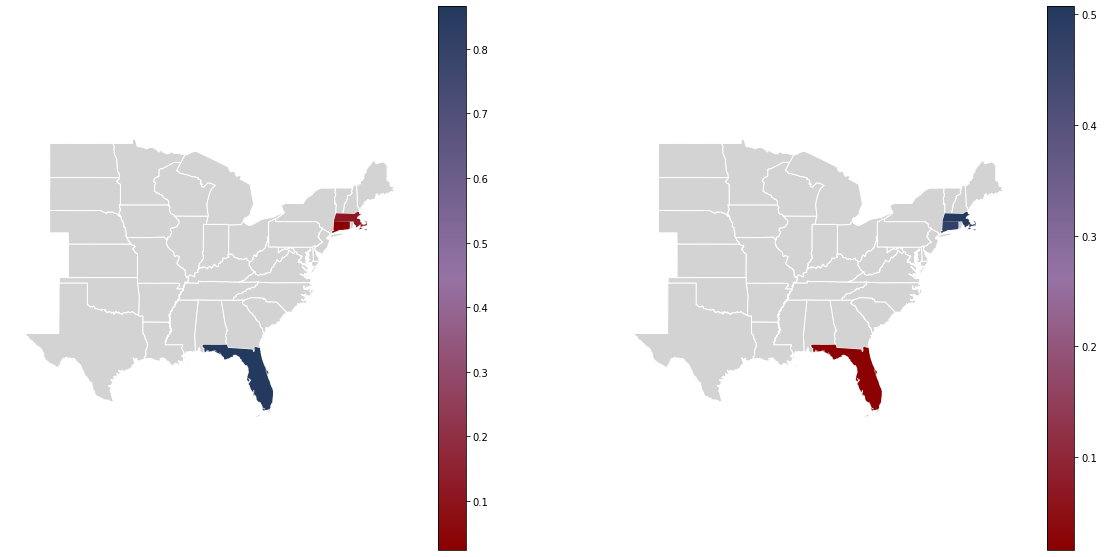

In [106]:
custom_cmap = col.LinearSegmentedColormap.from_list("", ["#8b0000","#9673A5", "#23395D"])

map_file['location'] = map_file[name_of_resolution]

with_movements = map_file.merge(df)

def make_source_sink_maps(df):

    fig, ax = plt.subplots(1,2, figsize=(20,10))

    map_file.plot(ax=ax[0], color="lightgrey", edgecolor="white")
    map_file.plot(ax=ax[1], color="lightgrey", edgecolor="white")

    with_movements.plot(ax=ax[0], column='average_source', cmap=custom_cmap, legend=True)
    with_movements.plot(ax=ax[1], column='average_sink', cmap=custom_cmap, legend=True)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.savefig("source-sink_map.pdf", bbox_inches="tight")